In [1]:
import MGTomo.model as mgmodel
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch

from MGTomo.gridop import P,R

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [2,10,10,2]

In [3]:
N = 511
# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

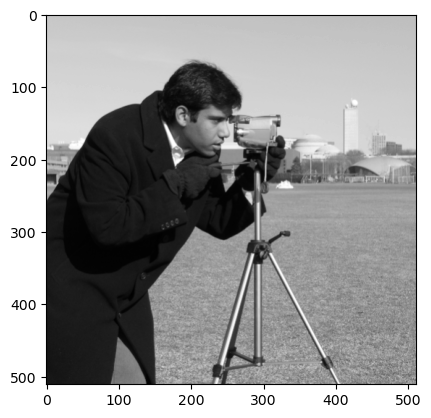

In [4]:
plt.imshow(x_torch.detach().numpy(), cmap = 'gray')

In [5]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [6]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [7]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [8]:
c0 = 56.0952
tau0 = 0.5 * 1/c0

In [9]:
def coarse_condition(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        y_norm = matrix_norm(y, ord = 1)
        return gcond and (y_diff_norm >= eta * y_norm)
    else:
        #print('y_last was none')
        return gcond

In [10]:
def MLO(fh, y, last_pts: list, l=0, kappa = 0.5, eta = 1e-1):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
        print(l, ' : coarse correction activated')
        
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * (x-x0))

        for i in range(maxIter[l+1]):
            #print(l, ': psi - ', i)
            x.retain_grad()
            val = fcts.SMART(psi, x, tau[l+1])
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO(psi, x, last_pts, l+1)

        assert psi(x) < psi(x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    d = P(x-x0)
    z, a = armijo_linesearch(fh, y0, d)
    
    assert z.min() >= 0
    
    for i in range(maxIter[l]):
        #print(l, ': fh - ', i)
        z.retain_grad()
        zval = fcts.SMART(fh, z, tau[l])
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    return z, last_pts, a

In [11]:
tau = [tau0]*(max_levels+1)

In [12]:
a = []
z0 = torch.rand(N, N, requires_grad = True)
last_pts = [None]*(max_levels+1)
print(fh(z0))
i = 0
while fh(z0) >= 0.5:
    val, ylast, alpha = MLO(fh, z0, last_pts)
    print(i, ': ', alpha)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    print(i, ': ', fh(z0))
    i += 1

tensor(313223.4339, dtype=torch.float64, grad_fn=<AddBackward0>)
0  : coarse correction activated
at a =  0.125 f_new is <= and x_new.min() =  tensor(-0.3109, grad_fn=<MinBackward1>) with #<0:  tensor(21573)
at a =  0.0625 f_new is <= and x_new.min() =  tensor(-0.1532, grad_fn=<MinBackward1>) with #<0:  tensor(10408)
at a =  0.03125 f_new is <= and x_new.min() =  tensor(-0.0750, grad_fn=<MinBackward1>) with #<0:  tensor(5026)
at a =  0.015625 f_new is <= and x_new.min() =  tensor(-0.0360, grad_fn=<MinBackward1>) with #<0:  tensor(2385)
at a =  0.0078125 f_new is <= and x_new.min() =  tensor(-0.0174, grad_fn=<MinBackward1>) with #<0:  tensor(1104)
at a =  0.00390625 f_new is <= and x_new.min() =  tensor(-0.0084, grad_fn=<MinBackward1>) with #<0:  tensor(505)
at a =  0.001953125 f_new is <= and x_new.min() =  tensor(-0.0039, grad_fn=<MinBackward1>) with #<0:  tensor(188)
at a =  0.0009765625 f_new is <= and x_new.min() =  tensor(-0.0019, grad_fn=<MinBackward1>) with #<0:  tensor(38)
at a

AssertionError: psi(x) < psi(x0) = fH(x0) does not hold

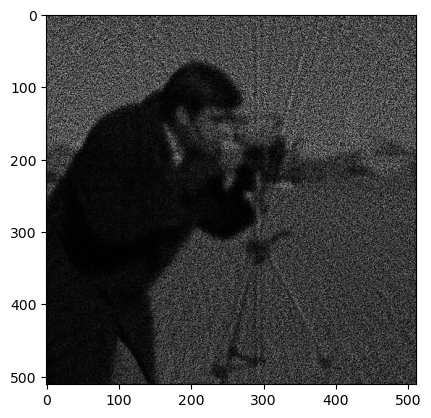

In [14]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')

In [13]:
z0

tensor([[0.1388, 0.0391, 1.3867,  ..., 1.5410, 0.9651, 0.0170],
        [1.5641, 1.2458, 1.1182,  ..., 0.6153, 1.1490, 1.1206],
        [0.3633, 0.1199, 0.0687,  ..., 1.1192, 0.4294, 0.5511],
        ...,
        [0.0576, 0.0750, 0.0000,  ..., 0.7072, 0.8320, 0.8220],
        [0.0000, 0.1545, 0.1746,  ..., 0.2731, 0.7796, 0.1868],
        [0.1399, 0.1057, 0.1811,  ..., 1.1125, 0.9423, 0.4143]],
       requires_grad=True)